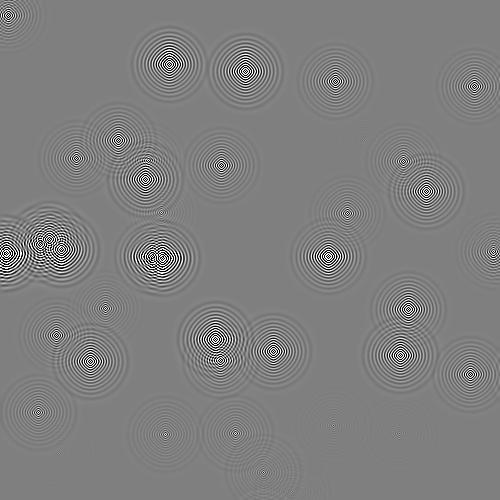

In [12]:
import tensorflow as tf
import numpy as np
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

def make_kernel(a):
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

N = 500

u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

tf.global_variables_initializer().run()

for i in range(1000):
  step.run({eps: 0.03, damping: 0.04})
  DisplayArray(U.eval(), rng=[-0.1, 0.1])